In [247]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline

In [248]:
import warnings
warnings.simplefilter("ignore", UserWarning) # ignore UserWarnings

import scipy.optimize

def solve_bar_gamma(n, Sigma):
    "Solves for \bar{gamma} = \lambda^{-1} in l2-norm det equiv"
    d = Sigma.shape[0]
    eigs = np.linalg.eigvalsh(Sigma)
    res = scipy.optimize.minimize(
        lambda gam: ((d-n) - (1.0 / (1.0 + gam*eigs)).sum())**2,
        1.0,
        constraints=({
            'type': 'ineq',
            'fun': lambda gam: gam,
        })
    )
    return res.x[0]

# Investigate $E[1/(\sum_i \lambda_i z_i^2)] = E[(z^\top D z)^{-2}] \overset{?}{\leq} C (\mathrm{Tr}~D)^{-2}$.

It looks like the constant $C$ depends on $\lambda_{\min}(D)$, so it's not universal :(

In [257]:
d = 64

xs = list()
for lambda_min in [1, 1e-1, 1e-4]:
    D = np.logspace(0, np.log10(lambda_min), num=d)
    D[1] = 1

    for _ in range(10000):
        z = np.random.randn(d)
        x = (z.T @ np.diag(D) @ z)**(-2)
        xs.append({
            'lambda_min': lambda_min,
            'x': (x - (D.sum())**(-2))**2,
        })
    
df = pd.DataFrame(xs)

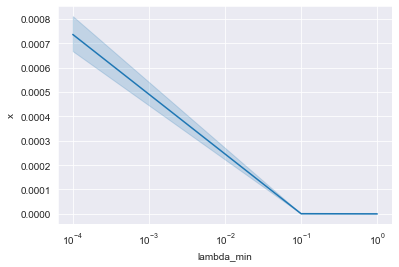

In [258]:
fig, ax = plt.subplots()
ax.set(xscale="log")
sns.lineplot(x='lambda_min', y='x', data=df, ax=ax)

# Implicit regularization and bias correction

In [261]:
d = 128

xs = list()
#for lambda_min in [1, 1e-1, 1e-2, 1e-3]:
for lambda_min in [1, 1e-1, 1e-2]:
    D = np.diag(np.logspace(1, np.log10(lambda_min), num=d))
    w = np.random.randn(d)
    w /= np.linalg.norm(w)

    #for n in [2,4,8,16,32,64]:
    for n in [8,32,64]:
        E_w_pinv = np.zeros(d)
        barQinv_E_inv_w_pinv = np.zeros(d)
        
        n_trials = 1000
        for _ in range(n_trials):
            X = np.random.randn(n,d) @ np.sqrt(D)

            w_pinv = np.linalg.pinv(X) @ X @ w
            E_w_pinv += w_pinv

            import scipy.optimize

            res = scipy.optimize.minimize_scalar(
                lambda g: (np.trace(np.linalg.inv(g*D + np.eye(d))) - d + n)**2,
                method='bounded',
                bounds=(n/d, n/(d-n))
            )
            gamma_bar = res.x
            barQinv = np.linalg.inv(D + gamma_bar**(-1) * np.eye(d)) @ D
            barQinv = np.linalg.inv(barQinv)

            barQinv_E_inv_w_pinv += barQinv @ w_pinv

        xs.append({
            'lambda_min': lambda_min,
            'n': n,
            'd': d,
            'w_pinv_se': ((E_w_pinv / n_trials - w)**2).sum(),
            'w_bar_se': ((barQinv_E_inv_w_pinv / n_trials - w)**2).sum(),
        })

In [262]:
df = pd.DataFrame(xs)
df

,lambda_min,n,d,w_pinv_se,w_bar_se
0,1.00,8,128,0.878593,0.461697
1,1.00,32,128,0.567478,0.216895
2,1.00,64,128,0.265693,0.035738
3,0.10,8,128,0.891575,0.199933
4,0.10,32,128,0.619698,0.013700
5,0.10,64,128,0.325802,0.002176
6,0.01,8,128,0.898982,0.194112
7,0.01,32,128,0.636173,0.169848
8,0.01,64,128,0.338989,1.652104


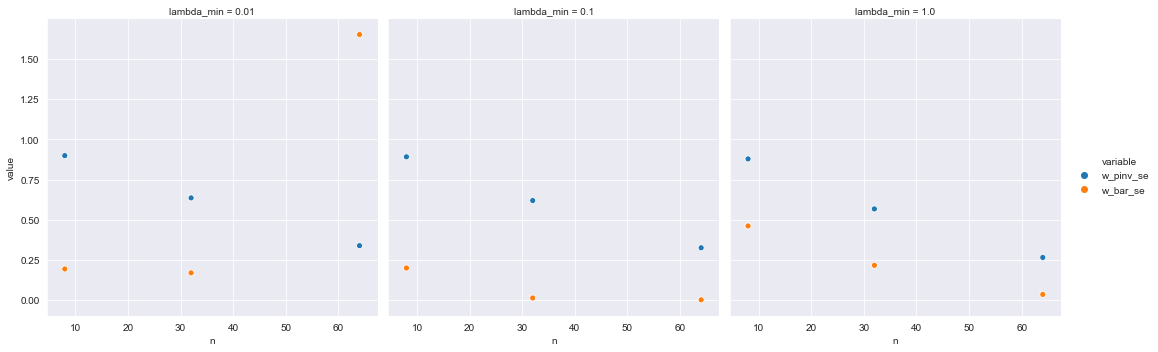

In [263]:
sns.relplot(
    data=pd.melt(df, value_vars=['w_pinv_se', 'w_bar_se'], id_vars=['n', 'd', 'lambda_min']),
    hue='variable',
    y='value',
    x='n',
    col='lambda_min')

# Implicit regularization deterministic equivalents

**Question**: Stochastic control theory has general conditions for $\sup E = E \sup$. Can we extend the
[upward filtering condition](https://mathoverflow.net/questions/107887/when-do-maximum-and-expectation-commute)
to two functions and high probability inequalities, then apply Fatou's lemma conditionally to get our results?

Let $\rho_1$ and $\rho_2$ be norms on $\mathbb{R}^d$,
$L : \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}_{\geq 0}$ a loss function.

Covariance types:
 * $\|\Sigma\|_2 = 1$
 * $\lambda_{\min}(\Sigma) = 1 / \kappa$
 * `exp` - exponential decay
 * `linear` - linear decay
 * `spike_XX` - top XX fraction have eigenvalue 1, remainder have $\lambda_{\min}$
 
 We want to hold $\rho = r / n = Tr(\Sigma) / n \|\Sigma\|$ fixed, increase $r$, and hope to see $C_{\rho} K^2 / \sqrt{r}$ difference in operator norm.

In [37]:
def run_simulation(w_star, Sigma, n, rho_1, rho_2, rho_1_name, rho_2_name, num_trials=100):
    d = Sigma.shape[0]

    # estimate implicit regularization (LHS - RHS)**2
    LHS = np.zeros(d)
    for _ in range(num_trials):
        X = np.random.randn(n,d) @ np.sqrt(Sigma)
        LHS += np.linalg.pinv(X) @ X @ w_star # NOTE; ignoring noise xi since zero expectation
    LHS /= num_trials
    lam = 1.0 / solve_bar_gamma(n, Sigma)
    
    RHS = (Sigma / (Sigma + lam)) @ w_star
    return ((LHS - RHS)**2).sum()

## Initial Gaussian experiments

In [82]:
import itertools

from tqdm.notebook import tqdm

norms = [
    (lambda w: np.linalg.norm(w, 2), 'l2'),
    #(lambda w: np.sqrt(w.T @ Sigma @ w), 'Sigma-norm'), # use Sigma for A in mahalanobis
    #(lambda w: np.linalg.norm(w, 1), 'l1'),
]
covs = [
    ('exp', lambda kappa, d: np.diag(np.logspace(0, np.log10(1.0 / kappa), num=d))),
    ('linear', lambda kappa, d: np.diag(np.linspace(1, 1.0 / kappa, num=d))),
    ('spike_0.1', lambda kappa, d: np.diag([
        1.0 if i < 0.1*d else 1.0 / kappa for i in range(d)
    ])),
    ('spike_0.9', lambda kappa, d: np.diag([
        1.0 if i < 0.9*d else 1.0 / kappa for i in range(d)
    ])),
]

xs = list()
for (
    (rho_1, rho_1_name),
    (rho_2, rho_2_name),
) in tqdm([
    (a,a) for a in norms  # only consider rho_1 = rho_2
], desc='norms'):
    for d in tqdm([16, 32, 64, 128, 256, 512], desc='d'): # this is like varying r
        w_star = np.ones(d) / np.sqrt(d)
        for kappa in tqdm([2, 10, 100], desc='kappa'):
            for (cov_type, Sigma_thunk) in tqdm(covs, desc='Sigma'):
                Sigma = Sigma_thunk(kappa, d)
                r = np.trace(Sigma) / np.linalg.norm(Sigma, 2) # since it uniquely determines r
                for rho in tqdm([1.1, 1.5, 2, 4], desc='rho'): # as rho is held fixed
                    n = int(np.ceil(r * 1.0 / rho))
                    
                    se = run_simulation(w_star, Sigma, n, rho_1, rho_2, rho_1_name, rho_2_name, num_trials=20000)
                    xs.append({
                        'd': d,
                        'cond_num': kappa,
                        'cov_type': cov_type,
                        'r': r,
                        'rho': rho,
                        'n': n,
                        'rho_1': rho_1_name,
                        'rho_2': rho_2_name,
                        'se': se,
                    })

KeyboardInterrupt: 

In [83]:
import pickle
# try:
#     df = df.append(pd.DataFrame(xs))
# except NameError:
#     df = pd.DataFrame(xs)
df = pd.DataFrame(xs)
#df['se_rel'] = df['se'] / (df['LHS_l2']**2)
#pickle.dump(df, open('results.pkl', 'wb'))
#df = pickle.load(open('results.pkl', 'rb'))

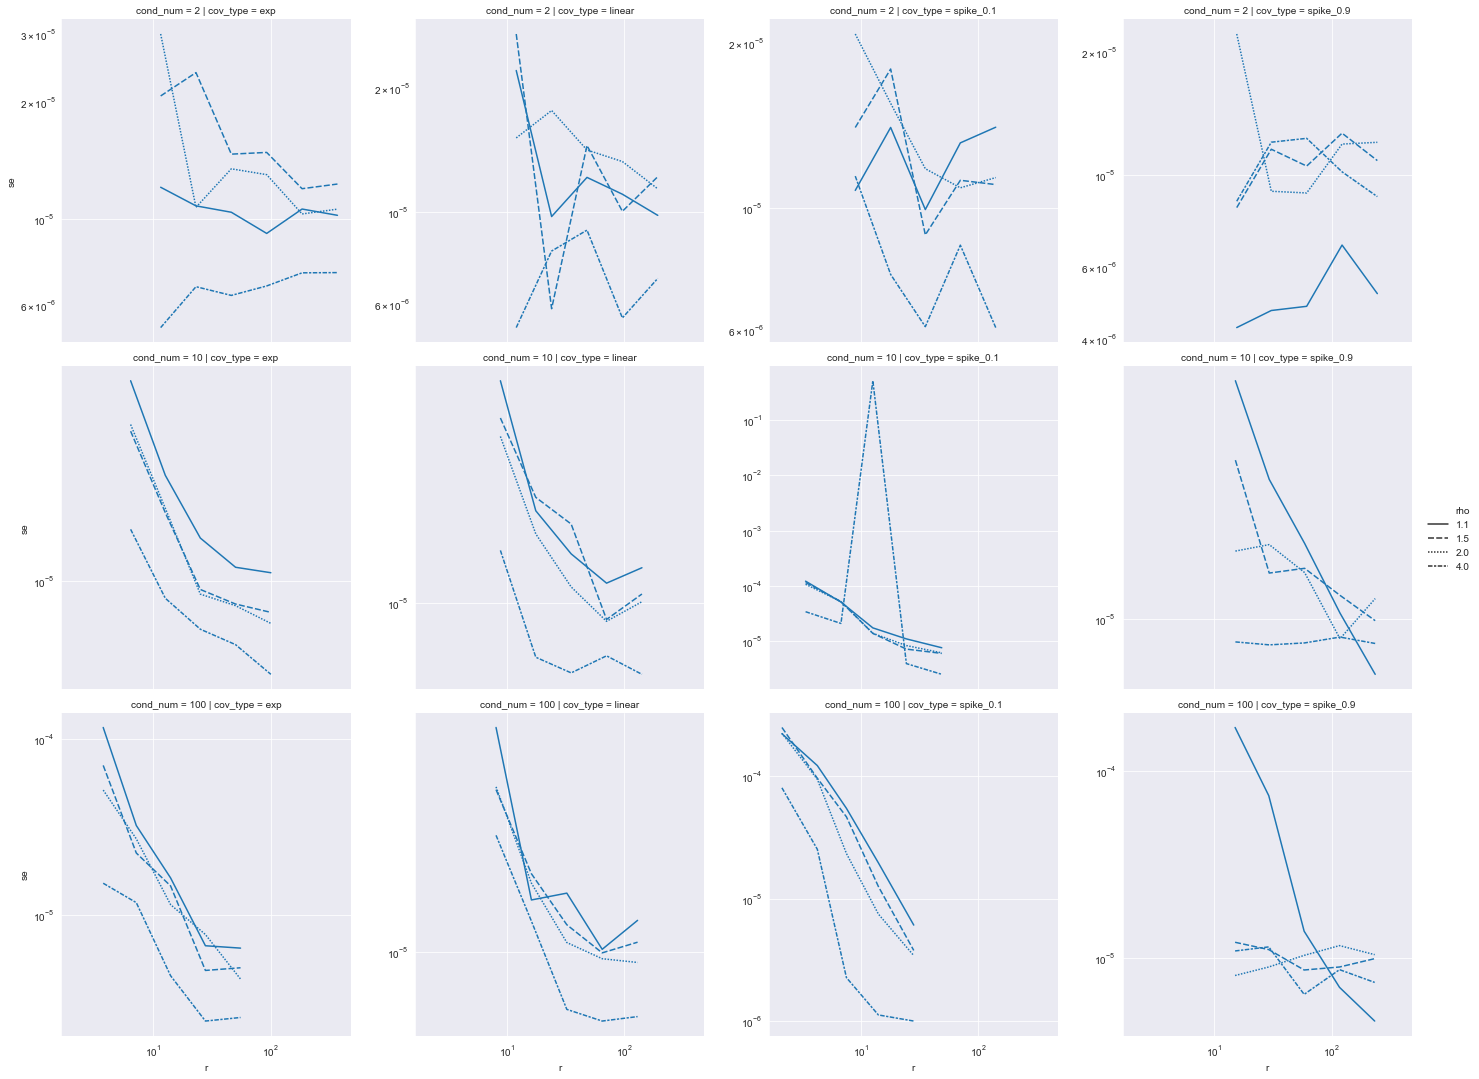

In [84]:
norm_name = 'l2'
df_sub = df[
    (df['rho_1'] == norm_name)
    & (df['rho_2'] == norm_name)
    & (pd.notna(df['r']))
    & (df['n'] < df['d'])
] 
fg = sns.relplot(
    data=df_sub,
    y='se',
    x='r',
    #group='cov_type',
    #col='cond_num',
    row='cond_num',
    col='cov_type',
    style='rho',
    #hue='n',
    kind='line',
    facet_kws={'sharey': False, 'sharex': True})
for axs in fg.axes:
    for ax in axs:
        ax.set(xscale='log', yscale='log')
fg.fig.show()

In [85]:
fg.fig.savefig('l2-impreg-fixrho.png')

In [34]:
df_sub[
    (df_sub['cov_type'] == 'spike_0.9')
    #& (df_sub['n'] == 16)
    & (df_sub['cond_num'] == 2)
]

,d,cov_type,cond_num,r,n,rho_1,rho_2,LHS_l1,LHS_l2,RHS_l1,RHS_l2,se,se_rel
3,320,spike_0.9,2,304.0,16,l2,l2,0.890373,0.272684,0.890373,0.272684,0.073780,0.992247
15,160,spike_0.9,2,152.0,16,l2,l2,1.215238,0.272546,1.215238,0.272546,0.075684,1.018875
27,80,spike_0.9,2,76.0,16,l2,l2,1.866866,0.271926,1.866866,0.271926,0.106716,1.443208
39,40,spike_0.9,2,38.0,16,l2,l2,2.626184,0.268864,2.626184,0.268864,0.207872,2.875616
51,26,spike_0.9,2,25.0,16,l2,l2,3.125686,0.240193,3.125686,0.240193,0.348260,6.036450
63,20,spike_0.9,2,19.0,16,l2,l2,3.562796,0.281162,3.562796,0.281162,0.433750,5.486869
75,17,spike_0.9,2,16.5,16,l2,l2,3.894999,0.497540,3.894999,0.497540,0.225810,0.912194
99,640,spike_0.9,2,608.0,32,l2,l2,1.237481,0.272706,1.237481,0.272706,0.073391,0.986856
111,320,spike_0.9,2,304.0,32,l2,l2,1.775857,0.272637,1.775857,0.272637,0.077799,1.046663
123,160,spike_0.9,2,152.0,32,l2,l2,2.559967,0.272322,2.559967,0.272322,0.100569,1.356120


## Operator norm confidence intervals (thm 1), only kappa=10 exp decay

In [19]:
import itertools
import collections

from tqdm.notebook import tqdm

norms = [
    (lambda w: np.linalg.norm(w, 2), 'l2'),
]
covs = [
    ('exp', lambda kappa, d: np.diag(np.logspace(0, np.log10(1.0 / kappa), num=d))),
]
num_bootstraps = 100

xs = list()
for (
    (rho_1, rho_1_name),
    (rho_2, rho_2_name),
) in tqdm([
    (a,a) for a in norms  # only consider rho_1 = rho_2
], desc='norms'):
    for d in tqdm([16, 32, 64, 128, 256, 512], desc='d'): # this is like varying r
        for kappa in tqdm([10], desc='kappa'):
            for (cov_type, Sigma_thunk) in tqdm(covs, desc='Sigma'):
                Sigma = Sigma_thunk(kappa, d)
                r = np.trace(Sigma) / np.linalg.norm(Sigma, 2) # since it uniquely determines r
                for rho in tqdm([1.5, 2, 4], desc='rho'): # as rho is held fixed
                    n = int(np.ceil(r * 1.0 / rho))
                    Sigma_sqrt = np.sqrt(Sigma) # OK because Sigma is diagonal
                        
                    bar_gamma = solve_bar_gamma(n, Sigma)
                    bar_P_inv = bar_gamma * Sigma + np.eye(d)

                    # bootstrapping (cf https://arxiv.org/pdf/1909.06120.pdf)
                    # NOTE: the reference technically is for covariance matrices, not projections
                    num_trials = 10000
                    done = False

                    while not done:
                        bs_EPs = np.zeros((num_bootstraps, d, d))
                        hat_EP = np.zeros((d,d))

                        # bootstrap_resamples[j][i] is the amount of times the ith trials is resampled
                        # in the jth bootstrap
                        bootstrap_resamples = list()
                        for j in range(num_bootstraps):
                            bootstrap_resamples.append(
                                collections.Counter(
                                    np.random.choice(np.arange(num_trials), replace=True, size=num_trials)))
                        
                        # one pass to draw both samples and bootstrap resamples
                        for i in range(num_trials):
                            X = np.random.randn(n, d) @ Sigma_sqrt
                            P = np.eye(d) - np.linalg.pinv(X) @ X
                            hat_EP += P / num_trials
                            
                            for j in range(num_bootstraps):
                                bs_EPs[j] += bootstrap_resamples[j][i] * P / num_trials
                        hat_err = np.linalg.norm(hat_EP @ bar_P_inv - np.eye(d), 2)
                        
                        # redraw bootstrap samples
                        bs_err = 0
                        for j in range(num_bootstraps):
                            bs_err += np.linalg.norm(bs_EPs[j] @ bar_P_inv - np.eye(d), 2) / num_bootstraps
                        bs_err_std = np.sqrt(((bs_err - hat_err)**2).mean())
                        
                        if bs_err_std < hat_err / 3:
                            print(f"done")
                            done = True
                        else:
                            print(f"num_trials={num_trials}, hat_err={hat_err}, bs_err_std={bs_err_std}")
                            num_trials *= 2
                            
                    xs.append({
                        'n': n,
                        'd': d,
                        'r': r,
                        'rho': rho,
                        'cond_num': kappa,
                        'cov_type': cov_type,
                        'num_trials': num_trials,
                        'num_bootstraps': num_bootstraps,
                        'err': hat_err,
                        'err_std_bs': bs_err_std,
                    })

done
done
done





done
done
done





done
done
done





num_trials=10000, hat_err=0.016157865089599033, bs_err_std=0.005633982821485212
num_trials=20000, hat_err=0.011900424084606643, bs_err_std=0.004115761691543452
done
done
num_trials=10000, hat_err=0.0086727466807359, bs_err_std=0.0032751643770377783
num_trials=20000, hat_err=0.006604776197409726, bs_err_std=0.0022744722332033477
done





num_trials=10000, hat_err=0.015676202244650852, bs_err_std=0.00586115093790231
num_trials=20000, hat_err=0.011119967462009462, bs_err_std=0.004257112239723734
done
num_trials=10000, hat_err=0.011951814779599283, bs_err_std=0.005376940121642446
done
num_trials=10000, hat_err=0.008269126466357687, bs_err_std=0.003509697051555221
num_trials=20000, hat_err=0.00588933460022545, bs_err_std=0.0025752262492066526
num_trials=40000, hat_err=0.004440565503155398, bs_err_std=0.0017104601131456964
num_trials=80000, hat_err=0.0033484007673624553, bs_err_std=0.0011814984761349314
num_trials=160000, hat_err=0.0024872308286318493, bs_err_std=0.0008565048447462982
done





num_trials=10000, hat_err=0.014636522507402258, bs_err_std=0.0063432153666897785
num_trials=20000, hat_err=0.010680398909067306, bs_err_std=0.004325230759847884
num_trials=40000, hat_err=0.007640839649880504, bs_err_std=0.003080733199132434







KeyboardInterrupt: 

In [4]:
import pickle
#df = pd.DataFrame(xs)
#pickle.dump(df, open("thm1-errorbars.pkl", "wb"))
df = pickle.load(open("thm1-errorbars.pkl", "rb"))

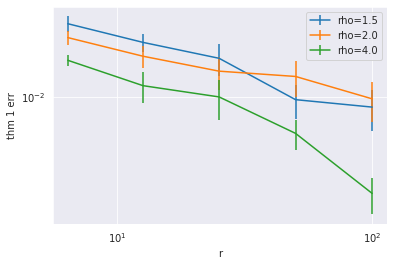

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for c in df['rho'].unique():
    df_sub = df.loc[df['rho'] == c]
    plt.errorbar(df_sub['r'], df_sub['err'], yerr=df_sub['err_std_bs'], label=f"rho={c}")
    
plt.xlabel('r')
plt.ylabel('thm 1 err')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

## Do the same for Rademacher sketches

In [43]:
import itertools
import collections

from tqdm.notebook import tqdm

norms = [
    (lambda w: np.linalg.norm(w, 2), 'l2'),
]
covs = [
    ('exp', lambda kappa, d: np.diag(np.logspace(0, np.log10(1.0 / kappa), num=d))),
]
num_bootstraps = 100

xs = list()
for (
    (rho_1, rho_1_name),
    (rho_2, rho_2_name),
) in tqdm([
    (a,a) for a in norms  # only consider rho_1 = rho_2
], desc='norms'):
    for d in tqdm([16, 32, 64, 128, 256, 512], desc='d'): # this is like varying r
        for kappa in tqdm([10], desc='kappa'):
            for (cov_type, Sigma_thunk) in tqdm(covs, desc='Sigma'):
                Sigma = Sigma_thunk(kappa, d)
                r = np.trace(Sigma) / np.linalg.norm(Sigma, 2) # since it uniquely determines r
                for rho in tqdm([1.5, 2, 4], desc='rho'): # as rho is held fixed
                    n = int(np.ceil(r * 1.0 / rho))
                    Sigma_sqrt = np.sqrt(Sigma) # OK because Sigma is diagonal
                        
                    bar_gamma = solve_bar_gamma(n, Sigma)
                    bar_P_inv = bar_gamma * Sigma + np.eye(d)
                    bar_P_inv_sqrt = scipy.linalg.sqrtm(bar_P_inv)

                    # bootstrapping (cf https://arxiv.org/pdf/1909.06120.pdf)
                    # NOTE: the reference technically is for covariance matrices, not projections
                    num_trials = 10000
                    done = False

                    while not done:
                        bs_EPs = np.zeros((num_bootstraps, d, d))
                        hat_EP = np.zeros((d,d))

                        # bootstrap_resamples[j][i] is the amount of times the ith trials is resampled
                        # in the jth bootstrap
                        bootstrap_resamples = list()
                        for j in range(num_bootstraps):
                            bootstrap_resamples.append(
                                collections.Counter(
                                    np.random.choice(np.arange(num_trials), replace=True, size=num_trials)))
                        
                        # one pass to draw both samples and bootstrap resamples
                        for i in range(num_trials):
                            X = (2*(np.random.uniform(size=(n,d)) > 0.5) - 1) @ Sigma_sqrt
                            P = np.eye(d) - np.linalg.pinv(X) @ X
                            hat_EP += P / num_trials
                            
                            for j in range(num_bootstraps):
                                bs_EPs[j] += bootstrap_resamples[j][i] * P / num_trials
                        hat_err = np.linalg.norm(bar_P_inv_sqrt @ hat_EP @ bar_P_inv_sqrt - np.eye(d), 2)
                        
                        # redraw bootstrap samples
                        bs_err = 0
                        for j in range(num_bootstraps):
                            bs_err += np.linalg.norm(bar_P_inv_sqrt @ bs_EPs[j] @ bar_P_inv_sqrt - np.eye(d), 2) / num_bootstraps
                        bs_err_std = np.sqrt(((bs_err - hat_err)**2).mean())
                        
                        if bs_err_std < hat_err / 6:
                            print(f"done")
                            done = True
                        else:
                            print(f"num_trials={num_trials}, hat_err={hat_err}, bs_err_std={bs_err_std}")
                            num_trials *= 2
                            
                    xs.append({
                        'n': n,
                        'd': d,
                        'r': r,
                        'rho': rho,
                        'cond_num': kappa,
                        'cov_type': cov_type,
                        'num_trials': num_trials,
                        'num_bootstraps': num_bootstraps,
                        'err': hat_err,
                        'err_std_bs': bs_err_std,
                    })

num_trials=10000, hat_err=0.019919197977728436, bs_err_std=0.00440934721010576
num_trials=20000, hat_err=0.014273756223769307, bs_err_std=0.004582632219334776
done
num_trials=10000, hat_err=0.02075650133954488, bs_err_std=0.00379945139031811
done
done





num_trials=10000, hat_err=0.015776716777397032, bs_err_std=0.0064382771987633765
num_trials=20000, hat_err=0.014285477791265218, bs_err_std=0.0029217080872464413
num_trials=40000, hat_err=0.010210791168231302, bs_err_std=0.0025238377666888592
num_trials=80000, hat_err=0.009171883403343437, bs_err_std=0.001571518691158241
done
num_trials=10000, hat_err=0.016253569786932827, bs_err_std=0.00398910500790077
num_trials=20000, hat_err=0.013086440925544186, bs_err_std=0.0026564442701408047
num_trials=40000, hat_err=0.009683048794168259, bs_err_std=0.0021565418144499967
done
num_trials=10000, hat_err=0.011059104304940967, bs_err_std=0.0033939825022115573
done





num_trials=10000, hat_err=0.01577167969874002, bs_err_std=0.0060176715466691705
num_trials=20000, hat_err=0.011695241971213358, bs_err_std=0.003893143607776633
num_trials=40000, hat_err=0.00825362498169694, bs_err_std=0.002836830194548704
num_trials=80000, hat_err=0.006165324389406267, bs_err_std=0.0021066458430698846
num_trials=160000, hat_err=0.005295976922517574, bs_err_std=0.001267435246421594
num_trials=320000, hat_err=0.0045596948066332745, bs_err_std=0.0008549358345151924
done
num_trials=10000, hat_err=0.012156202381455969, bs_err_std=0.005273486229151449
num_trials=20000, hat_err=0.009876890817179, bs_err_std=0.0033954825678720133
num_trials=40000, hat_err=0.007621286840889806, bs_err_std=0.002141318914161412
num_trials=80000, hat_err=0.005938828430512237, bs_err_std=0.0017997120381367058
num_trials=160000, hat_err=0.005129848964236693, bs_err_std=0.000978044164412462
done
num_trials=10000, hat_err=0.009308750374961355, bs_err_std=0.003623044160869086
num_trials=20000, hat_err=

num_trials=10000, hat_err=0.015035471598912359, bs_err_std=0.006142437419291571
num_trials=20000, hat_err=0.01086472946344204, bs_err_std=0.004249247698994228
num_trials=40000, hat_err=0.008464673112668625, bs_err_std=0.002623432403871877
num_trials=80000, hat_err=0.005708876812661597, bs_err_std=0.0022194133752067883
num_trials=160000, hat_err=0.004287500593080734, bs_err_std=0.0014661171498993979
num_trials=320000, hat_err=0.0035964562100836354, bs_err_std=0.0008612225337951657
num_trials=640000, hat_err=0.0027560283098255153, bs_err_std=0.0006235808343196193
num_trials=1280000, hat_err=0.002217270653865046, bs_err_std=0.0004570227914461292
done
num_trials=10000, hat_err=0.013457797088761455, bs_err_std=0.004470829162933123
num_trials=20000, hat_err=0.009077328822651973, bs_err_std=0.003713838281065071
num_trials=40000, hat_err=0.006746280579413318, bs_err_std=0.002559288915588544
num_trials=80000, hat_err=0.005243917367687632, bs_err_std=0.0016736354093651526
num_trials=160000, hat_

num_trials=10000, hat_err=0.014136347761802049, bs_err_std=0.006497781688630872
num_trials=20000, hat_err=0.010203545134301282, bs_err_std=0.004553955355275871
num_trials=40000, hat_err=0.007603803751165618, bs_err_std=0.0028900171392879552
num_trials=80000, hat_err=0.005602006287906605, bs_err_std=0.001995897697819468
num_trials=160000, hat_err=0.0041776065281272125, bs_err_std=0.0013156280873042317
num_trials=320000, hat_err=0.0029399751592801525, bs_err_std=0.001012581968822173
num_trials=640000, hat_err=0.002151023782499377, bs_err_std=0.0007478680717131103
num_trials=1280000, hat_err=0.001682915559634348, bs_err_std=0.0005056465630965908







KeyboardInterrupt: 

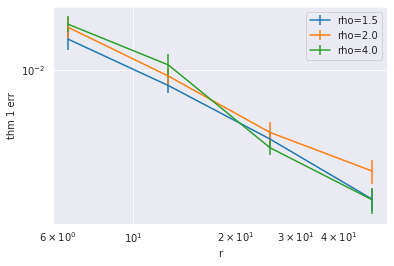

In [6]:
import matplotlib.pyplot as plt
import pickle

#df2 = pd.DataFrame(xs)
#pickle.dump(df2, open("thm1-rademacher-errorbars.pkl", "wb"))
df2 = pickle.load(open("thm1-rademacher-errorbars.pkl", "rb"))


fig, ax = plt.subplots()

for c in df['rho'].unique():
    df_sub = df2.loc[df2['rho'] == c]
    plt.errorbar(df_sub['r'], df_sub['err'], yerr=df_sub['err_std_bs'], label=f"rho={c}")
    
plt.xlabel('r')
plt.ylabel('thm 1 err')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [35]:
df2

,n,d,r,rho,cond_num,cov_type,num_trials,num_bootstraps,err,err_std_bs
0,5,16,6.424484,1.5,10,exp,10000,100,0.998194,1.729750e-04
1,4,16,6.424484,2.0,10,exp,10000,100,0.998623,1.229416e-04
2,2,16,6.424484,4.0,10,exp,10000,100,0.999022,8.020297e-05
3,9,32,12.672386,1.5,10,exp,10000,100,1.000000,1.776357e-15
4,7,32,12.672386,2.0,10,exp,10000,100,1.000000,5.107026e-15
5,4,32,12.672386,4.0,10,exp,10000,100,1.000000,2.664535e-15
6,17,64,25.177238,1.5,10,exp,10000,100,1.000000,1.287859e-14
7,13,64,25.177238,2.0,10,exp,10000,100,1.000000,2.162714e-13
8,7,64,25.177238,4.0,10,exp,10000,100,1.000000,1.931788e-14
9,34,128,50.191219,1.5,10,exp,10000,100,1.000000,1.620926e-14


# Low rank sketching results

Gaussian sketch, A = U Sigma V' full rank with U and V uniformly sampled from Steiffel manifolds, Sigma exponential decay

## Synthetic

In [1]:
def generate_A(m, n, cov_type, rs=None, kappa=10):
    assert cov_type == 'exp', NotImplemented
    rank = min(m, n)
    Sigma = np.diag(np.logspace(0, np.log10(1.0 / kappa), num=rank))
    U = scipy.stats.ortho_group.rvs(m, random_state=rs)
    V = scipy.stats.ortho_group.rvs(n, random_state=rs)
    if rank == m:
        V = V[:,:rank]
    else:
        U = U[:,:rank]
    return U @ Sigma @ V.T

In [125]:
import itertools
import collections

from tqdm.notebook import tqdm

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

rs = RandomState(MT19937(SeedSequence(42)))

num_trials = 10000
kappa = 10

xs = list()

#for n in tqdm([16, 32, 64, 128, 256, 512, 1024, 2048], desc='n'): # this is effectively varying r
for n in tqdm([16, 32, 64], desc='n'): # this is effectively varying r
    for AR in tqdm([0.1, 0.5, 1.0, 2, 10], desc='AR'): # aspect ratio of A = m / n
        for rho in tqdm([1.1, 1.5, 2, 4, 10], desc='rho'): # rho = r / k
            m = int(np.ceil(AR * n))
            A = generate_A(m, n, 'exp', rs)
            r = np.linalg.norm(A, 'fro')**2 / np.linalg.norm(A, 2)**2

            k = int(r / rho)
            gamma_bar = solve_bar_gamma(k, A @ A.T)
            P_bar = np.linalg.inv(gamma_bar * (A @ A.T) + np.eye(m)) @ (gamma_bar * (A @ A.T))
            det_eq_pred = np.trace(A @ A.T @ (np.eye(m) - P_bar))

            for _ in range(num_trials):
                S = rs.randn(n, k)
                P = (A @ S) @ np.linalg.pinv(A @ S)
                error = np.linalg.norm(A - (P @ A), 'fro')**2

                xs.append({
                    'AR': AR,
                    'kappa': kappa,
                    'n': n,
                    'm': m,
                    'r': r,
                    'k': k,
                    'rho': rho,
                    'variable': 'error',
                    'value': error,
                    'delta': error - det_eq_pred,
                })

KeyboardInterrupt: 

In [4]:
import pandas as pd
import pickle

#df = pd.DataFrame(xs)
#pickle.dump(df, open('sketching.pkl', 'wb'))

df = pickle.load(open('sketching.pkl', 'rb'))

In [10]:
df['delta_rel'] = df['delta'] / df['value']

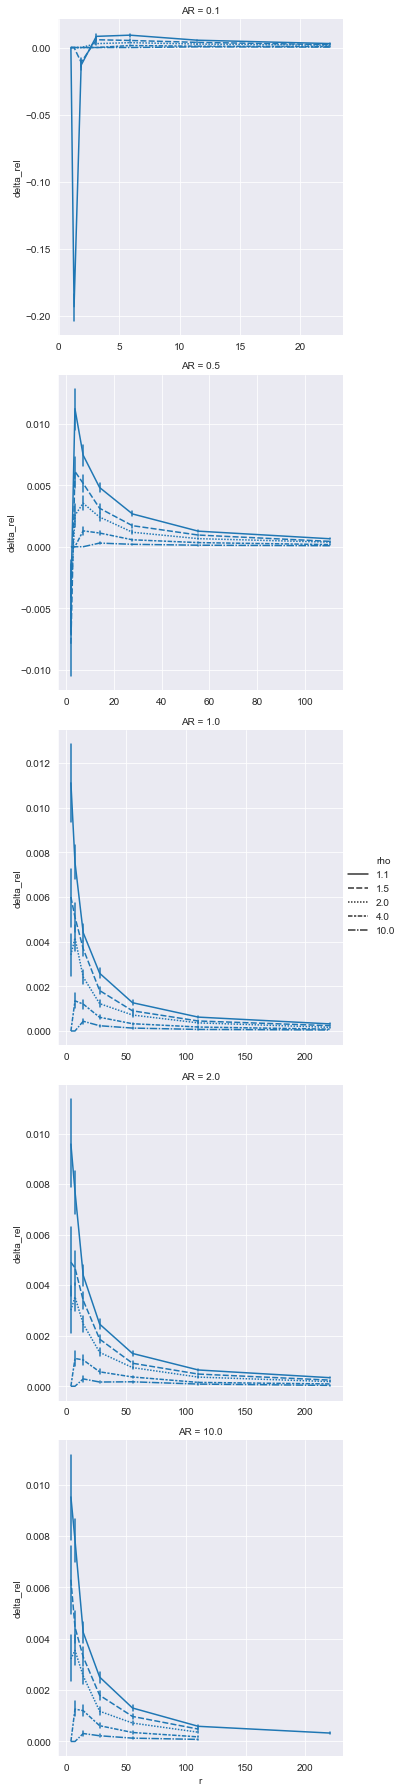

In [11]:
import seaborn as sns
sns.set_style('darkgrid')

df_prep = df

sns.relplot(
    data=df_prep,
    x='r',
    y='delta_rel',
    style='rho',
    row='AR',
    #col='rho',
    kind='line',
    err_style='bars',
    ci=95,
    facet_kws={
        'sharey': False,
        'sharex': False,
    }
)

## libsvm data

In [426]:
import numexpr as ne
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
from scipy.linalg.blas import sgemm
from sklearn.datasets import load_svmlight_file
from tqdm.notebook import tqdm

rs = RandomState(MT19937(SeedSequence(42)))



def rbf(X, gamma, var):
    X_norm = -gamma*np.einsum('ij,ij->i',X,X)
    return ne.evaluate('v * exp(A + B + C)', {\
        'A' : X_norm[:,None],\
        'B' : X_norm[None,:],\
        'C' : sgemm(alpha=2.0*gamma, a=X, b=X, trans_b=True),\
        'g' : gamma,\
        'v' : var\
    })
def soft_rank(X):
    return np.linalg.norm(X, 'fro')**2 / np.linalg.norm(X, 2)**2


num_trials = 100
xs = list()
for dataset in tqdm([
#       'abalone_scale',
#       'housing_scale',
#       'mg_scale',
#      'mpg_scale',
#       'pyrim_scale',
#       'triazines_scale',
       'bodyfat_scale',
       'cpusmall_scale',
       'splice_scale',
    ]):
    A_orig, _ = load_svmlight_file(f"./data/{dataset}")
    A = A_orig.todense()

    A_AT = A @ A.T
    m, n = A.shape
    r = np.linalg.norm(A_AT, 'fro')**2 / np.linalg.norm(A_AT, 2)**2
    for k in tqdm(range(1, 30)):
        rho = r / k
        gamma_bar = solve_bar_gamma(k, A_AT)
        P_bar = np.linalg.inv(gamma_bar * (A_AT) + np.eye(m)) @ (gamma_bar * (A_AT))
        det_eq_pred = np.trace(A_AT @ (np.eye(m) - P_bar))
        
        for _ in range(num_trials):
            errors = list()
            for S in [
                rs.randn(n, k),
                2*(rs.rand(n,k) > 0.5)-1,
            ]:
                P = (A @ S) @ np.linalg.pinv(A @ S)
                error = np.linalg.norm(A - (P @ A), 'fro')**2
                errors.append(error)
            xs.append({
                'AR': m/n,
                #'kappa': np.linalg.cond(A),
                'n': n,
                'm': m,
                'r': r,
                'k': k,
                'bar_gamma': gamma_bar,
                'rho': rho,
                'err_fro_gauss': errors[0],
                'err_fro_rad': errors[1],
                'err_de': det_eq_pred,
                'dataset': dataset,
            })

In [432]:
df1 = pd.DataFrame(xs)
#pickle.dump(df1, open('sketching-libsvm-gauss-rad.pkl', 'wb'))

Above, we first truncate $A$'s SVD so that it's lower rank. This is strictly for tractability in computing the SVD.

The following changes are made to handle large $A$ in the experiments:

(A): When $d$ is too large we get overflows on the $\bar{\gamma}$ optimization. To improve stability, we can cancel $d$ out. Letting $\Sigma = A A^\top$ where $A \in \mathbb{R}^{n \times d}$ has singular values `s`

$$
d - k = Tr(\bar{\gamma} \Sigma + I) = \sum_{i=1}^{rank(\Sigma)} \frac{1}{1 + \bar{\gamma} s_i^2} + (d - rank(\Sigma)) \\
rank(\Sigma) - k = \sum_{i=1}^{rank(\Sigma)} \frac{1}{1 + \bar{\gamma} s_i^2}
$$

We use this equation for solving for $\bar{\gamma}$. Also note that since the RHS is bounded below by $0$,
we have the requirement $k \leq rank(\Sigma) = rank(A)$.

(B): The $\bar{P}$ is $d \times d$ and cannot fit (33GB when $d=70k$ on `real-sim` dataset) in memory. Since the deterministic equivalent prediction is a trace, if we let `A = u @ np.diag(s) @ vt` be its SVD
(so in particular $\Sigma = u s^2 u^\top$) then
$$
\begin{align*}
Tr(A A^\top (I_d - \bar{P}))
&= Tr( u s^2 u^\top (I_d - \bar{\gamma} u s^2 u^\top (\bar{\gamma} u s^2 u^\top + I_d)^{-1})) \\
&= Tr( u s^2 u^\top (u u^\top - \bar{\gamma} u s^2 u^\top (\bar{\gamma} u s^2 u^\top + u u^\top)^{-1})) \\
&= Tr( u s^2 u^\top (u u^\top - \bar{\gamma} u s^2 u^\top u (\bar{\gamma} s^2 + I)^{-1} u^\top)) \\
&= Tr( u s^2 (u^\top - \bar{\gamma} s^2 (\bar{\gamma} s^2 + I)^{-1} u^\top)) \\
&= Tr( u s^2 (I - \bar{\gamma} s^2 (\bar{\gamma} s^2 + I)^{-1}) u^\top) \\
&= Tr( s^2 (I - \bar{\gamma} s^2 (\bar{\gamma} s^2 + I)^{-1}))
\end{align*}
$$
As `s` is diagonal, the last line is easy to evaluate for computing `det_eq_pred`.

(C): When forming the sketched $A S$ where $S \in \mathbb{R}^{d \times k}$ with $k < d$ (actually $k < rank(A)$, see discussion in (A)), since `A @ S = u @ s @ vt @ S` where `vt` has orthonormal rows, we have that `vt @ S` is also Gaussian but now of dimension $k = nrows(vt) \ll d$.

We use this to directly compute $AS$ without forming all $d$ random Gaussian rows of $S$.

(D): We need to compute $\|A - P A\|_F^2$, but cannot fit $P = (AS) (AS)^\dagger$ in memory, so instead we note
$$\begin{align*}
    A - P A
    &= A - (AS) (AS)^\dagger A \\
    &= (u s v^\top - (u s v^\top S) (AS)^\dagger (u s v^\top)) \\
    &= u (s - (s v^\top S) (AS)^\dagger (u s)) v^\top \\
    \|A - P A\|_F^2
    &= \| u (s - (s v^\top S) (AS)^\dagger (u s)) v^\top \|_F^2
    = \| (s - (s v^\top S) (AS)^\dagger (u s))\|_F^2
\end{align*}$$

In [250]:
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
from sklearn.datasets import load_svmlight_file
from tqdm.notebook import tqdm

rs = RandomState(MT19937(SeedSequence(42)))

svd_rank = 50
num_trials = 100

xs = list()

for dataset in [
    #'bodyfat_scale',
       #'cpusmall_scale',
       #'splice_scale',
    'real-sim',
    'cifar10',
    'SVHN',
]:
    A, _ = load_svmlight_file(f"./data/{dataset}")
    m, n = A.shape
    u, s, vt = scipy.sparse.linalg.svds(A, k=svd_rank)
    
    r = sum(s**2) / max(s**2)
    
    # need k < rank(A), which is svd_rank now
    for k in tqdm(range(1,svd_rank,5)):
        # hack (A)
#         res = scipy.optimize.minimize(
#             lambda gam: ((svd_rank - k) - (1.0 / (1.0 + gam*s**2)).sum())**2,
#             1.0,
#             constraints=({
#                 'type': 'ineq',
#                 'fun': lambda gam: gam,
#             }),
#         )
#         gamma_bar = res.x[0]
        res = scipy.optimize.root_scalar(
                    lambda gam: ((svd_rank - k) - (1.0 / (1.0 + gam*s**2)).sum()),
                    bracket=(0.0, 100.0),
                )
        gamma_bar = res.root

        # this overflows
        #P_bar = np.linalg.inv(gamma_bar * (A @ A.T) + np.eye(m)) @ (gamma_bar * (A @ A.T))
        #det_eq_pred = np.trace(A @ A.T @ (np.eye(m) - P_bar))

        # hack (B)
        det_eq_pred = (s**2 * (1 - gamma_bar*(s**2) / (gamma_bar*(s**2) + 1))).sum()

        for _ in range(num_trials):
            # another overflow
            #S = rs.randn(n, k)
            #P = (A @ S) @ np.linalg.pinv(A @ S)
            #error = np.linalg.norm(A - (P @ A), 'fro')**2

            # hack (C)
            errors = list()
            for vtS in [
                rs.randn(vt.shape[0], k),
        idx_bp = idx_sub.copy()            2*(rs.rand(vt.shape[0], k) > 0.5)-1,
            ]:
                AS = u @ np.diag(s) @ vtS
                # hack (D)
                error = np.linalg.norm(
                    (
                        np.diag(s) - (np.diag(s) @ vtS) @ np.linalg.pinv(AS) @ (u @ np.diag(s))
                        # A          (             P                      )        A   
                    ),
                    'fro')**2
                errors.append(error)
            
            xs.append({
                'AR': m/n,
                #'kappa': np.linalg.cond(A),
                'n': n,
                'm': m,
                'r': r,
                'k': k,
                'bar_gamma': gamma_bar,
                'rho': rho,
                'err_fro_gauss': errors[0],
                'err_fro_rad': errors[1],
                'err_de': det_eq_pred,
                'dataset': dataset,
            })

In [ ]:
df2 = pd.DataFrame(xs)
#df2 = pickle.dumps(df2, open('sketching-large-datasets-gauss-rad.pkl', 'wb'))

In [424]:
def plot_barchart_line(ax, df, dataset):
    
    df_melt = df.melt(
        id_vars=['dataset', 'k'],
        value_vars=['err_fro_rad', 'err_fro_gauss','err_de']
    ).groupby(['dataset', 'k', 'variable']).agg(list)
    
    # only index nonzero
    idx_sub = df_melt.loc[dataset,:,'err_fro_gauss'].index.get_level_values(1) < df[df['dataset'] == dataset].iloc[0]['n']   
    
    # subsample even finer for boxplots
    idx_bp = idx_sub.copy()
    n_idx = idx_bp.sum()
    if n_idx > 15:
        for i in range(idx_bp.shape[0]):
            idx_bp[i] &= (i % int(n_idx/10) == 0)
    
    data = [
        *df_melt.loc[dataset,:,'err_fro_gauss']['value'][idx_bp].values,
        *df_melt.loc[dataset,:,'err_fro_rad']['value'][idx_bp].values,
    ]
    width = (
        df_melt.loc[dataset,:,'err_fro_gauss'][idx_bp].index.get_level_values(1).max()
        - df_melt.loc[dataset,:,'err_fro_gauss'][idx_bp].index.get_level_values(1).min()
    ) / 30
    positions = [
        *df_melt.loc[dataset,:,'err_fro_gauss'][idx_bp].index.get_level_values(1)-width/1.5,
        *df_melt.loc[dataset,:,'err_fro_rad'][idx_bp].index.get_level_values(1)+width/1.5,
    ]
    bp = ax.boxplot(  
        data,
        positions=positions,
        widths=width,
        showfliers=False)

    # Now fill the boxes with desired colors
    num_boxes = len(data)
    medians = np.empty(num_boxes)
    for i in range(num_boxes):
        box = bp['boxes'][i]
        boxX = []
        boxY = []
        for j in range(5):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
        box_coords = np.column_stack([boxX, boxY])
        # Alternate between Dark Khaki and Royal Blue
        ax.add_patch(Polygon(box_coords, fill=False, linewidth=2, edgecolor=box_colors[int(i < num_boxes/2)]))
        # Now draw the median lines back over what we just filled in
#         med = bp['medians'][i]
#         medianX = []
#         medianY = []
#         for j in range(2):
#             medianX.append(med.get_xdata()[j])
#             medianY.append(med.get_ydata()[j])
#             ax.plot(medianX, medianY, 'k')
#         medians[i] = medianY[0]

    ax.plot(
        df_melt.loc[dataset,:,'err_de'].index.get_level_values(1).values[idx_sub],
        df_melt.loc[dataset,:,'err_de']['value'].map(np.min).values[idx_sub]
    )
    ax.set_xticks(df_melt.loc[dataset,:,'err_fro_gauss'][idx_bp].index.get_level_values(1))
    ax.set_xticklabels(df_melt.loc[dataset,:,'err_fro_gauss'][idx_bp].index.get_level_values(1))

    
    ax.set_title(dataset.replace('_', "\\_") + f", r={df[df['dataset'] == dataset].iloc[0]['r']:.2f}")

In [434]:
scipy.io.savemat("df_as_mat.mat", df)

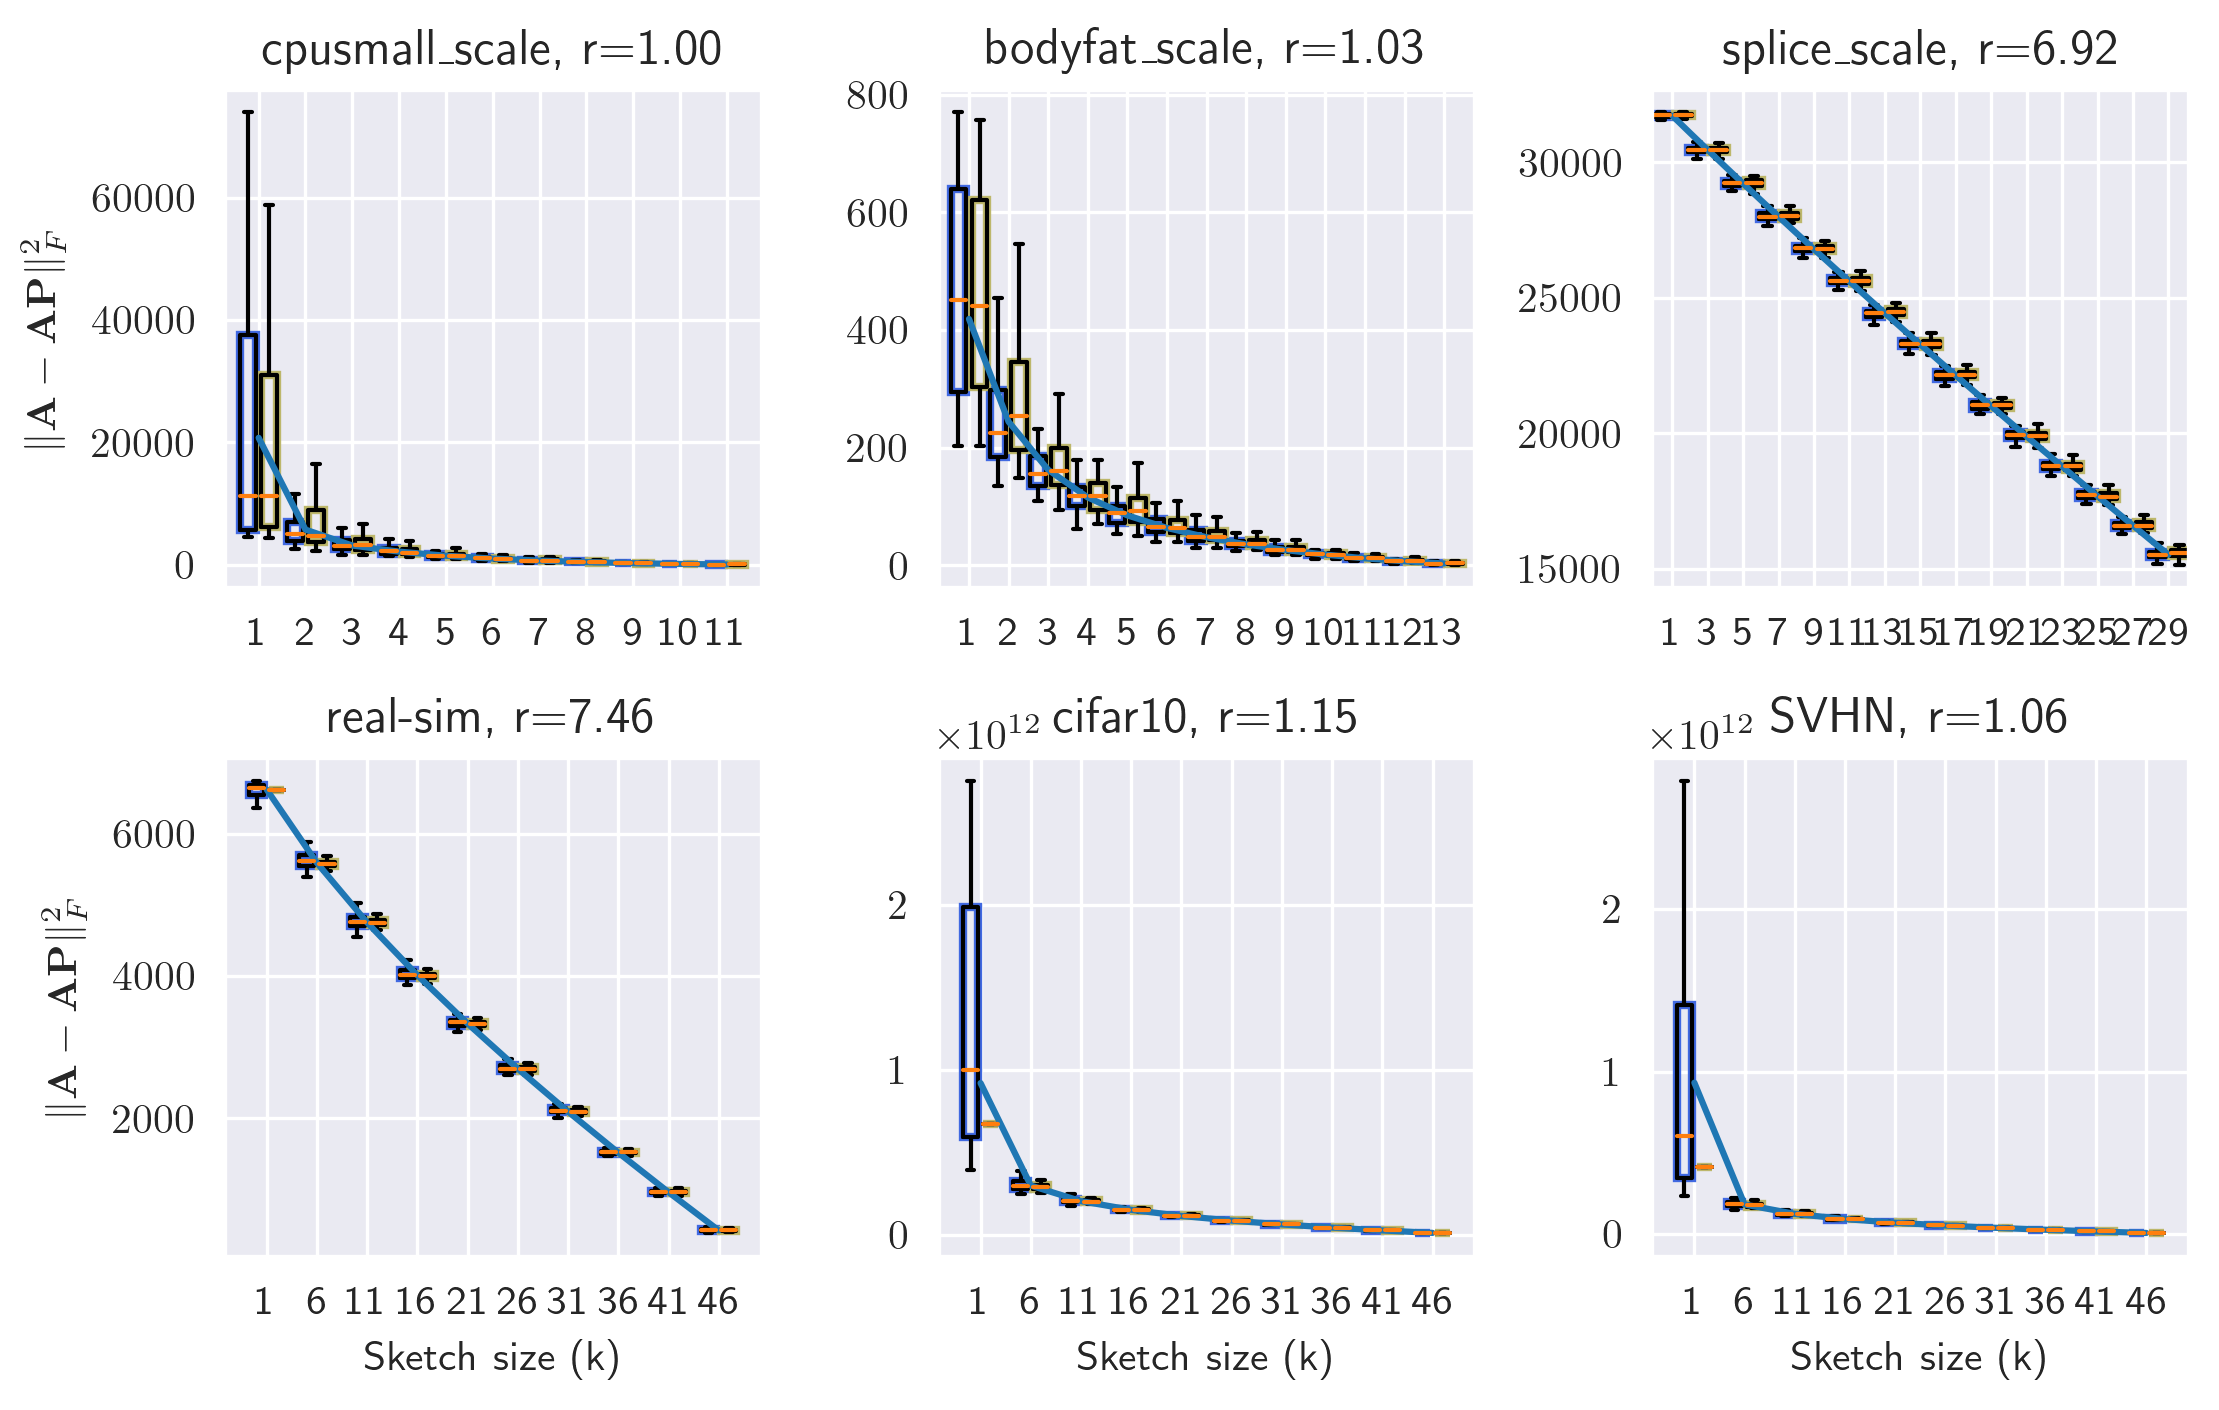

In [433]:
import pickle

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']

from matplotlib.patches import Polygon

import seaborn as sns
sns.set_style('darkgrid')

df1 = pickle.load(open('sketching-libsvm-gauss-rad.pkl', 'rb'))
df2 = pickle.load(open('sketching-large-datasets-gauss-rad.pkl', 'rb'))

df = df1.append(df2)

datasets = ['cpusmall_scale', 'bodyfat_scale', 'splice_scale', 'real-sim', 'cifar10', 'SVHN']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(7.5,4.8), dpi=300)
for i, dataset in enumerate(datasets):
    ax = axs[int(i/3), i%3]
    plot_barchart_line(ax, df, dataset)

    if i % 3 == 0:
        # only label leftmost
        ax.set_ylabel("$\|\mathbf{A} - \mathbf{A}\mathbf{P}\|_F^2$")
    if int(i/3) == 1:
        # only label bottom
        ax.set_xlabel("Sketch size (k)")

fig.tight_layout()

# fig.savefig('corollary1.png', dpi=300)
fig.show()

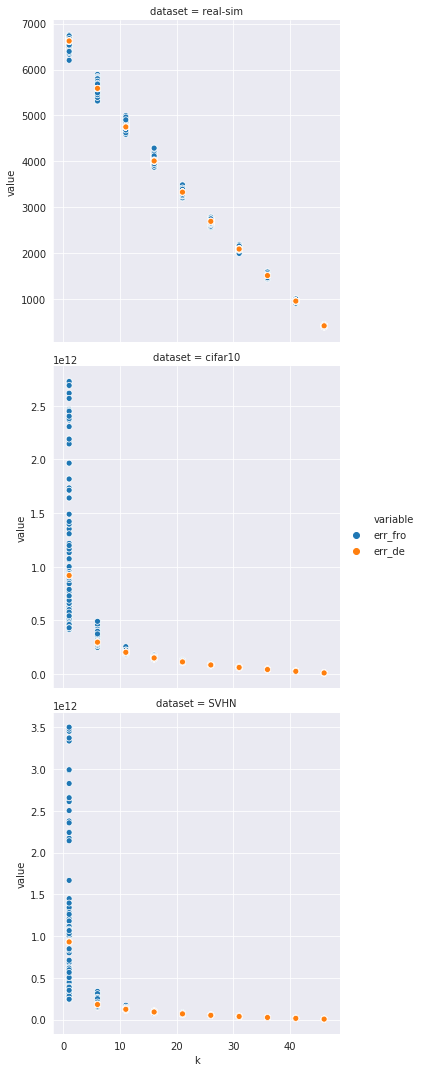

In [6]:
import seaborn as sns
sns.set_style('darkgrid')

#df = pickle.load(open('sketching-large-datasets.pkl', 'rb'))

df_melt = df.melt(
    id_vars=['dataset', 'k'],
    value_vars=['err_fro','err_de']
)

fg = sns.relplot(
    data=df_melt,
    x='k',
    y='value',
    row='dataset',
    hue='variable',
    facet_kws={ 'sharey': False },
)
fg

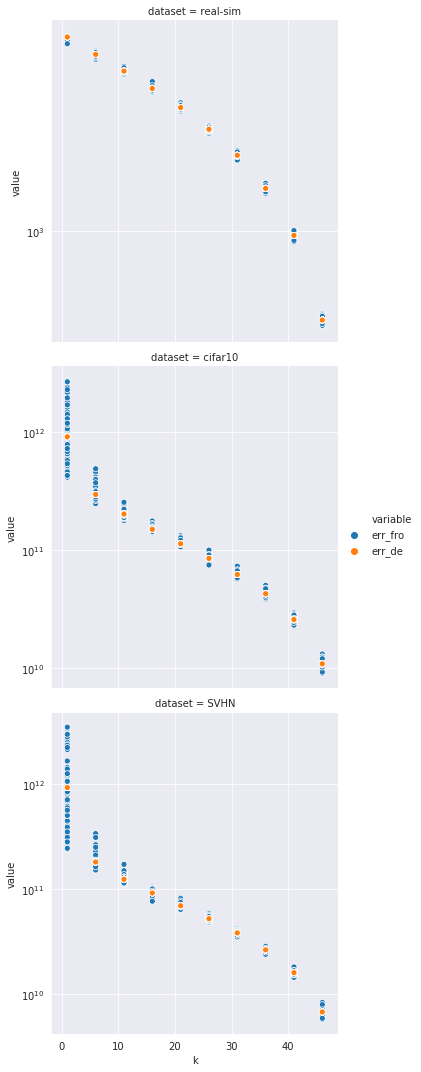

In [7]:
for ax_row in fg.axes:
    for ax in ax_row:
        ax.set_yscale('log')
fg.fig

## Kernel expansion

In [19]:
import numexpr as ne
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
from scipy.linalg.blas import sgemm
from sklearn.datasets import load_svmlight_file
from tqdm.notebook import tqdm

rs = RandomState(MT19937(SeedSequence(42)))



def rbf(X, gamma, var):
    X_norm = -gamma*np.einsum('ij,ij->i',X,X)
    return ne.evaluate('v * exp(A + B + C)', {\
        'A' : X_norm[:,None],\
        'B' : X_norm[None,:],\
        'C' : sgemm(alpha=2.0*gamma, a=X, b=X, trans_b=True),\
        'g' : gamma,\
        'v' : var\
    })
def soft_rank(X):
    return np.linalg.norm(X, 'fro')**2 / np.linalg.norm(X, 2)**2


num_trials = 10
xs = list()
for dataset in tqdm([
#       'abalone_scale',
#       'housing_scale',
#       'mg_scale',
#      'mpg_scale',
#       'pyrim_scale',
#       'triazines_scale',
       'bodyfat_scale',
       #'cpusmall_scale',
       #'splice_scale',
    ]):
    A_orig, _ = load_svmlight_file(f"./data/{dataset}")
    A_orig = A_orig.todense()
    
    #for rbf_bw in tqdm([10, 100, 1000]):
    for rbf_bw in tqdm([100, 10, 1, 0.1]):
        K = rbf(A_orig, rbf_bw, 1.0)
        A_AT = K
        K_sqrt = scipy.linalg.sqrtm(K)
        m, n = A_AT.shape
        r = np.linalg.norm(A_AT, 'fro')**2 / np.linalg.norm(A_AT, 2)**2
        for k in tqdm(range(1, 30)):
            rho = r / k
            gamma_bar = solve_bar_gamma(k, A_AT)
            P_bar = np.linalg.inv(gamma_bar * (A_AT) + np.eye(m)) @ (gamma_bar * (A_AT))
            #det_eq_pred = np.trace(A_AT @ (np.eye(m) - P_bar))
            det_eq_pred = np.trace(A_AT - K_sqrt @ P_bar @ K_sqrt)

            for _ in range(num_trials):
                errors = list()
                for S in [
                    rs.randn(n, k),
                    2*(rs.rand(n,k) > 0.5)-1,
                ]:
                    #P = (A @ S) @ np.linalg.pinv(A @ S)
                    #error = np.linalg.norm(A - (P @ A), 'fro')**2
                    C = K @ S
                    W = S.T @ C
                    K_tilde = C @ np.linalg.pinv(W) @ C.T
                    error = np.linalg.norm(K - K_tilde, 'nuc')
                    errors.append(error)
                xs.append({
                    'AR': m/n,
                    #'kappa': np.linalg.cond(A),
                    'n': n,
                    'm': m,
                    'r': r,
                    'k': k,
                    'bar_gamma': gamma_bar,
                    'rho': rho,
                    'err_fro_gauss': errors[0],
                    'err_fro_rad': errors[1],
                    'err_de': det_eq_pred,
                    'dataset': dataset,
                    'rbf_bw': rbf_bw,
                })

In [20]:
df = pd.DataFrame(xs)

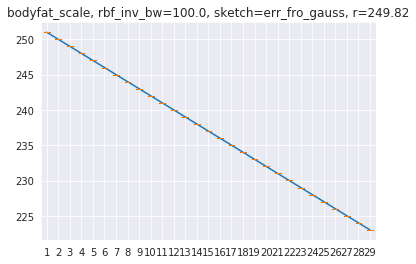

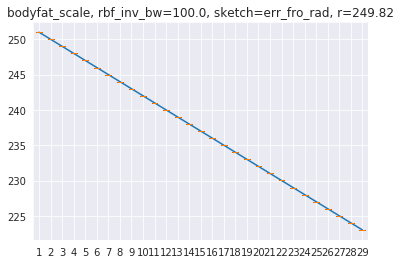

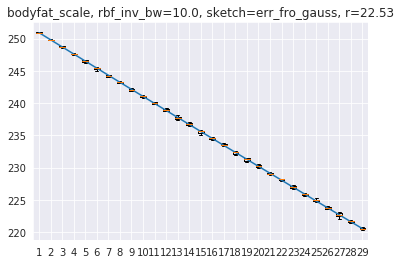

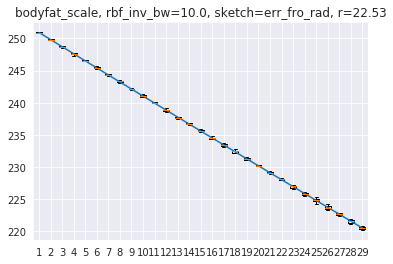

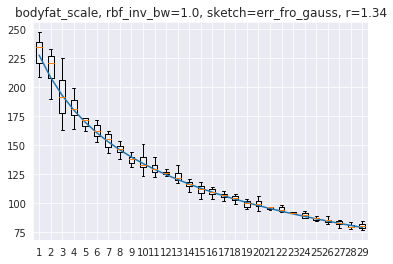

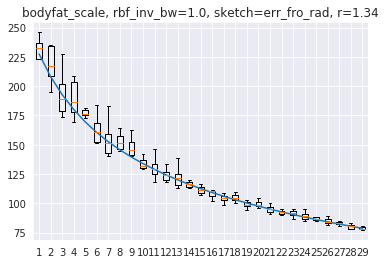

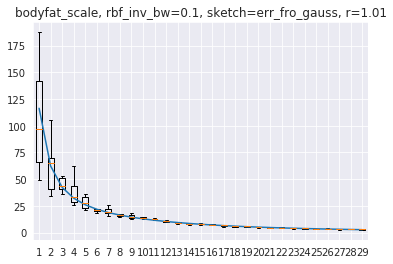

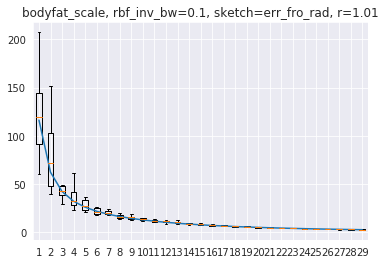

In [22]:
import pickle
import seaborn as sns
sns.set_style('darkgrid')

dataset = 'abalone_scale'

for dataset in tqdm([
#       'abalone_scale',
#       'housing_scale',
#       'mg_scale',
#      'mpg_scale',
#       'pyrim_scale',
#       'triazines_scale',
       'bodyfat_scale',
       'cpusmall_scale',
       'splice_scale',
    ]):
    df_melt = df.melt(
        id_vars=['dataset', 'k', 'rbf_bw'],
        value_vars=['err_fro_gauss', 'err_fro_rad', 'err_de']
    )
    for rbf_bw in df_melt['rbf_bw'].unique():
        for var in ['err_fro_gauss', 'err_fro_rad']:
            fig, ax = plt.subplots()

            df_sub = df_melt[
                (df_melt['dataset'] == dataset)
                & (df_melt['rbf_bw'] == rbf_bw)
                & (df_melt['variable'] == var)
                & (df_melt['k'] <= df[df['dataset'] == dataset].iloc[0]['n']) # filter out zeros
            ].groupby('k').agg(list)

            ax.boxplot(
                df_sub['value'],
                positions=df_sub.index,
                showfliers=False,
            )


            df_sub = df_melt[
                (df_melt['dataset'] == dataset)
                & (df_melt['rbf_bw'] == rbf_bw)
                & (df_melt['variable'] == 'err_de')
                & (df_melt['k'] <= df[df['dataset'] == dataset].iloc[0]['n']) # filter out zeros
            ].groupby('k').agg(np.min) # min = mean = max since constant

            ax.plot(
                df_sub['value'],
            )
            r = df[
                (df['dataset'] == dataset)
                & (df['rbf_bw'] == rbf_bw)
            ].iloc[0]['r']
            ax.set_title(f"{dataset}, rbf_inv_bw={rbf_bw}, sketch={var}, r={r:0.2f}")
            #fig.show()

This is a bit strange; we're forming $A$ as a kernel matrix (which is analogous to $A A^\top$ when $A$ is a data matrix) but then still taking $A A^\top$ in the deterministic equivalents and sketching $A S$ on the right.

There are a few options here.
The Nystrom approximation, while not applicable to our results, selects landmark points $\{x_i\}_{i \in L}$ and approximates
$$
K \approx K_{:,L} K_{L,L}^{-1} K_{L,:}
$$
Instead, random sketching methods can either sketch before the feature mapping $\phi$ so that $K(x, y) = \phi(x S)^\top \phi(y S)$ or sketch after the feature mapping i.e. $K(x,y) = \phi(x)^\top S^\top S \phi(y)$.
As our theory does not handle the non-linear feature mapping $\phi : \mathbb{R}^d \to H$ with Hilbert space representations, let's focus on the option where we sketch after the feature mapping.

Let $\Phi \in H^n$ have rows $\{\phi(x_i)\}_{i \in [n]}$. For $K = \Phi S^\top S \Phi^\top$, we will need $S : H \to H_2$ where $H_2$ is another Hilbert space. As our results are parameterized in sketch size $k$, we will
need to require $H_2 = \mathbb{R}^k$. What about $H$? It is infinite dimensional for many kernels of interest, e.g. the RBF kernel is an inner product between infinte dimensional polynomial feature vectors
$$
K(x,y) = \exp(-\gamma \|x - y\|_2^2) = C \sum_{n \geq 0} \frac{(x^\top y)^n}{n!}
$$

## Can we sketch to estimate Pbar?

Motivation: While using $\bar{P}$, we need to SVD $\Sigma = A A^\top$ which can be very expensive.

Try to approximate $\Sigma \approx \tilde{\Sigma} = (1/k) (\Sigma T) (\Sigma T)^\top$ where $T \in \mathbb{R}^{n \times k}$ is a sketching matrix. We will take $T = [S; U]$ where $U$ consists of another $l$ iid Gaussian columns. This is because the RHS for solving for $\bar{\gamma}$ is $rank(\tilde{\Sigma}) - k$, so we need $rank(\tilde{\Sigma}) > k$ which prohibits us from just using $\tilde{\Sigma} = (AS) (AS)^\top$.

For efficiency, we work directly with eigenvalues of $\tilde{\Sigma}$ (`sAS_full**2`).

In [385]:
# reduce problem to make tractable
svd_rank = 25
u, s, vt = scipy.sparse.linalg.svds(A, k=svd_rank)

In [395]:
num_trials = 100

xs = list()
for k in range(1, svd_rank, 10):
    # the full Pbar result
    res = scipy.optimize.root_scalar(
        lambda gam: ((svd_rank - k) - (1.0 / (1.0 + gam*s**2)).sum()),
        bracket=(0.0, 100.0),
    )
    gamma_bar = res.root
    det_eq_pred = (s**2 * (1 - gamma_bar*(s**2) / (gamma_bar*(s**2) + 1))).sum()
    
    for l in range(1,svd_rank-k, 2):
        for _ in range(num_trials):
            AS_full = u @ np.diag(s) @ rs.randn(vt.shape[0], k+l)
            _, sAS_full, _ = scipy.sparse.linalg.svds(AS_full, k=k+l-1, which='LM')
            _, sAS_full_min, _ = scipy.sparse.linalg.svds(AS_full, k=1, which='SM')
            sAS_full = np.hstack([sAS_full, sAS_full_min]) / np.sqrt(k+l) 
            res = scipy.optimize.root_scalar(
                # divide by k so spectrum estimates Sigma
                lambda gam: (((k+l) - k) - (1.0 / (1.0 + gam*(sAS_full**2))).sum()),
                bracket=(0.0, 100.0),
            )
            gamma_bar_subsamp = res.root
            det_eq_pred_subsamp = (sAS_full**2 * (1 - gamma_bar_subsamp*(sAS_full**2) / (gamma_bar_subsamp*(sAS_full**2) + 1))).sum()


            xs.append({
                'k': k,
                'l': l,
                'sq_trace_diff': ((sAS_full**2).sum() - (s**2).sum()) / (s**2).sum(),
                'gamma_bar_diff': (gamma_bar_subsamp - gamma_bar) / gamma_bar,
                'error_diff': (det_eq_pred_subsamp - det_eq_pred) / det_eq_pred,
            })

As a sanity check, we see that $\tilde{\Sigma}$ (`sAS_full`) and $\Sigma$ are close in expected Frobenius error.

It appears that the approximation is breaking down at `gamma_bar`. We are almost always overestimating `gamma_bar` leading to under-estimation of the error.

Increasing `l` makes things better as expected ($\tilde{\Sigma}$ has more samples, so better estimates $\Sigma$)

In [396]:
df = pd.DataFrame(xs)
df.groupby(['k', 'l']).mean()

sq_trace_diff  gamma_bar_diff  error_diff
k  l                                            
1  1       -0.015748        1.126317   -0.502050
   3        0.002509        0.380712   -0.255214
   5        0.017073        0.214109   -0.157521
   7       -0.001347        0.166237   -0.129408
   9        0.001987        0.116939   -0.097244
   11      -0.000204        0.104980   -0.086108
   13       0.009199        0.077911   -0.066253
   15       0.004489        0.077314   -0.064774
   17       0.003695        0.062911   -0.053467
   19       0.001049        0.058964   -0.050388
   21      -0.007002        0.062251   -0.052716
   23       0.001320        0.048158   -0.042756
11 1       -0.014346       12.082055   -0.921561
   3        0.006707        3.955236   -0.795550
   5        0.031300        2.278043   -0.690580
   7       -0.002268        1.671330   -0.623008
   9        0.008890        1.297483   -0.562149
   11      -0.002392        1.051501   -0.509411
   13      -0.000286        0.909681   -0.472914
21 1        0.003489       28.519094   -0.960707
   3        0.001288        8.554148   -0.888747

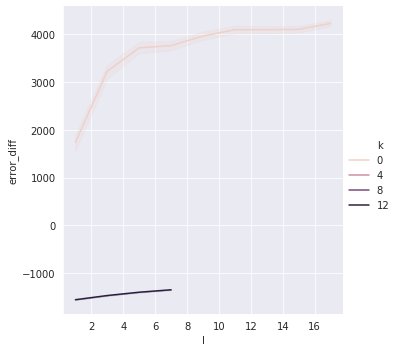

In [379]:
sns.relplot(data=df,
           x='l',
           y='error_diff',
           hue='k',
           kind='line')

# Plots for paper

In [2]:
!ls ./*.pkl

./results.pkl			./sketching.pkl
./sketching-large-datasets.pkl	./thm1-errorbars.pkl
./sketching-many-datasets.pkl	./thm1-rademacher-errorbars.pkl


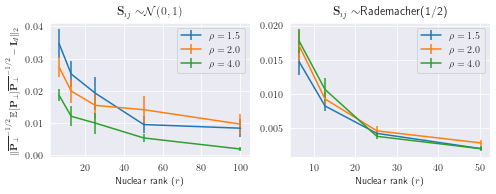

In [3]:
import pickle

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']

import seaborn as sns
sns.set_style('darkgrid')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7,2.8))

for i, (sketch_type, df) in enumerate([
    ("$\mathcal{N}(0,1)$", pickle.load(open("./thm1-errorbars.pkl", "rb"))),
    ('Rademacher(1/2)', pickle.load(open("thm1-rademacher-errorbars.pkl", "rb"))),
]):
    for c in df['rho'].unique():
        df_sub = df.loc[df['rho'] == c]
        axs[i].errorbar(df_sub['r'], df_sub['err'], yerr=df_sub['err_std_bs'], label=f"rho={c}")    
    axs[i].set_xlabel('Nuclear rank ($r$)')
    if i == 0:
        # only label leftmost
        axs[i].set_ylabel("$\|\overline{\mathbf{P}_\perp}^{-1/2} \mathbb{E}[\mathbf{P}_\perp] \overline{\mathbf{P}_\perp}^{-1/2} - \mathbf{I}_d\|_2$")
    axs[i].set_title("$\mathbf{S}_{ij} \sim$" + f'{sketch_type}')
    #axs[i].set_xscale('log')
    #axs[i].set_yscale('log')
    L = axs[i].legend()
    for t in L.get_texts():
        t.set_text("$" + t.get_text().replace('rho', "\\rho") + "$")
fig.tight_layout()
fig.savefig('theorem1.png', dpi=300)

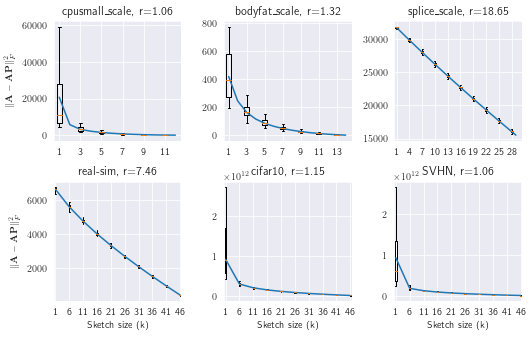

In [31]:
import pickle

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']

import seaborn as sns
sns.set_style('darkgrid')

df = pickle.load(open('sketching-large-datasets.pkl', 'rb'))
df = df.append(pickle.load(open('sketching-many-datasets.pkl', 'rb')))
df_melt = df.melt(
    id_vars=['dataset', 'k'],
    value_vars=['err_fro','err_de']
)

#datasets = df['dataset'].unique()
datasets = ['cpusmall_scale', 'bodyfat_scale', 'splice_scale', 'real-sim', 'cifar10', 'SVHN']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(7.5,4.8))
for i, dataset in enumerate(datasets):
    ax = axs[int(i/3), i%3]
    df_sub = df_melt[
        (df_melt['dataset'] == dataset)
        & (df_melt['variable'] == 'err_fro')
        & (df_melt['k'] <= df[df['dataset'] == dataset].iloc[0]['n']) # filter out zeros
    ].groupby('k').agg(list)
    
    # resample if too many x ticks
    if df_sub.shape[0] > 10:
        df_sub = df_sub[::int(np.ceil(df_sub.shape[0]/10))]
    
    ax.boxplot(
        df_sub['value'],
        positions=df_sub.index,
        showfliers=False,
    )

    
    df_sub = df_melt[
        (df_melt['dataset'] == dataset)
        & (df_melt['variable'] == 'err_de')
        & (df_melt['k'] <= df[df['dataset'] == dataset].iloc[0]['n']) # filter out zeros
    ].groupby('k').agg(np.min) # min = mean = max since constant
    
    ax.plot(
        df_sub['value'],
    )
    
    ax.set_title(dataset.replace('_', "\\_") + f", r={df[df['dataset'] == dataset].iloc[0]['r']:.2f}")
    
    if i % 3 == 0:
        # only label leftmost
        ax.set_ylabel("$\|\mathbf{A} - \mathbf{A}\mathbf{P}\|_F^2$")
    if int(i/3) == 1:
        # only label bottom
        ax.set_xlabel("Sketch size (k)")

    
fig.tight_layout()
fig.savefig('corollary1.png', dpi=300)

In [7]:
import numpy as np
import scipy
from sklearn.datasets import load_svmlight_file

for dataset in [
  'abalone_scale',
  'housing_scale',
  'mg_scale',
  'mpg_scale',
  'pyrim_scale',
  'triazines_scale',
  'cpusmall_scale',
  'bodyfat_scale',
  'splice_scale',
  #'real-sim',
  #'cifar10',
  #'SVHN',
]:
    A, _ = load_svmlight_file(f"./data/{dataset}")
    A = A.todense()
    r = scipy.linalg.norm(A, 'fro')**2 / scipy.linalg.norm(A, 2)**2
    print(dataset.replace('_', '\\_') + f" & {A.shape[0]} & {A.shape[1]} & {A.shape[0] / A.shape[1]:.2g} & {r:.2f} " + "\\\\")

abalone\_scale & 4177 & 8 & 5.2e+02 & 1.57 \\
housing\_scale & 506 & 13 & 39 & 1.75 \\
mg\_scale & 1385 & 6 & 2.3e+02 & 2.32 \\
mpg\_scale & 392 & 7 & 56 & 1.85 \\
pyrim\_scale & 74 & 27 & 2.7 & 1.50 \\
triazines\_scale & 186 & 60 & 3.1 & 1.40 \\
cpusmall\_scale & 8192 & 12 & 6.8e+02 & 1.06 \\
bodyfat\_scale & 252 & 14 & 18 & 1.32 \\
splice\_scale & 1000 & 60 & 17 & 18.65 \\


In [26]:
!ls data/

abalone_scale	housing_scale  mpg	     splice
bodyfat_scale	madelon        mpg_scale     splice_scale
cifar10.bz2	mg	       pyrim_scale   SVHN.bz2
cpusmall_scale	mg_scale       real-sim.bz2  triazines_scale


In [27]:
!bunzip2 data/*.bz2